## Project Stage - III (Basic Machine Learning)

## Goals

The goal of Stage III is to utlize machine learning and statistical models to predict the trend of COVID-19 cases / deaths.

### Tasks:

#### Task 1: (70 pts)
- Team: (30)
    - Develop Linear and Non-Linear (polynomial) regression models for predicting cases and deaths in US. 
        - Start your data from the first day of infections in US. X-Axis, number of days since the first case, Y-Axis number of new cases and deaths.
        - Aim to predict 1 week in advance. Use older data to validate your models. Use Root Mean Square Error (RMSE) to see the evaluation. 
        - Describe the trends as compared to other countries. 
- Member: (40 pts)
    - Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties. Start your data from the first day of infections. X-Axis, number of days since the first case, Y-Axis number of new cases and deaths. Calcluate error using RMSE.
    - Identify which counties are most at risk. Model for top 5 counties with cases within a state and observe their trends.
    - Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.
    - Utilize decision tree, random forest, and ARIMA (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases. 
    - Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county. Compare Random Forest and Decision Trees (RMSE error).
        - For example, percentage of population in certain age-group, socio-economic status, public transportation, work from home, etc.
        - Show the relative importance of variables and explain why. 
    
#### Task 2: (30 pts)
- Member:
    - For each of the aforemention analysis plot graphs,
        - trend line
        - confidence intervals (error in prediction)
        - prediction path

**Deliverable**
- Report upload on canvas.
- Each member creates separate notebooks for member tasks. Upload all notebooks to Github Repository. 

# Deadline: 11/15/2020

## Import libraries

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import cufflinks as cf
# import plotly.plotly as py
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objs as go
from datetime import datetime,timedelta
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import kurtosis,skew,poisson
import statistics as st
import plotly.io as pio
from IPython.display import Image
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error


## Set credentials for using plotly

In [436]:
tls.set_credentials_file(username='ritupandey1', api_key='xfclHpjv0I99MaxeDKN5')

## Read merged COVID19 csv file 

In [437]:
# COVID-19 dataset
COVID19 = "../Data/Output/Merged_COVID19_file.csv"
merged_COVID19 = pd.read_csv(COVID19)


## Format date into datetime

In [438]:
merged_COVID19['dates'] = pd.to_datetime(merged_COVID19.dates)
merged_COVID19.head()

,countyFIPS,stateFIPS,dates,County Name,State,population,confirmed_cases,deaths
0,0,2,2020-01-22,Statewide Unallocated,AK,0,0,0
1,0,2,2020-01-23,Statewide Unallocated,AK,0,0,0
2,0,2,2020-01-24,Statewide Unallocated,AK,0,0,0
3,0,2,2020-01-25,Statewide Unallocated,AK,0,0,0
4,0,2,2020-01-26,Statewide Unallocated,AK,0,0,0


## Member: Task 1

#### Selected state is Virginia

- Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties. Start your data from the first day of infections. X-Axis, number of days since the first case, Y-Axis number of new cases and deaths. Calcluate error using RMSE.

## -Preprocessing data to extract new cases and number of days from day one.

In [439]:
# The merged file contains the total confirmed cases and total deaths upto that day.
merged_COVID19_VA = merged_COVID19[merged_COVID19['State']=='VA'].copy()
population_VA = merged_COVID19_VA.groupby('dates')['population'].sum()[1]
print('Population of Virginia is : ',population_VA)

# Find new cases county wise
COVID19_VA_new_cases = merged_COVID19_VA.copy()
COVID19_VA_new_cases['conf_diff'] = merged_COVID19_VA.sort_values(['County Name','dates'])['confirmed_cases'].diff().fillna(0)
COVID19_VA_new_cases['deaths_diff'] = merged_COVID19_VA.sort_values(['County Name','dates'])['deaths'].diff().fillna(0)
# COVID19_VA_new_cases['No_of_Days'] = merged_COVID19_VA.sort_values(['County Name','dates'])['dates'].diff().fillna(timedelta(days=0).days)
COVID19_VA_new_cases['No_of_Days'] = (merged_COVID19_VA.sort_values(['County Name','dates'])['dates'] - pd.to_datetime('2020-01-22')).apply(lambda x:x.days)


print(COVID19_VA_new_cases['No_of_Days'].dtype)
# Replace negative values with 0 for conf_diff and deaths_diff
COVID19_VA_new_cases['conf_diff'] = np.where(COVID19_VA_new_cases['conf_diff']<0,0,COVID19_VA_new_cases['conf_diff'])
COVID19_VA_new_cases['deaths_diff'] = np.where(COVID19_VA_new_cases['deaths_diff']<0,0,COVID19_VA_new_cases['deaths_diff'])
# COVID19_VA_new_cases['days'] = COVID19_VA_new_cases['No_of_Days'].apply(lambda x:x.days)

mask = COVID19_VA_new_cases[COVID19_VA_new_cases['County Name']=='Statewide Unallocated'].index
COVID19_VA_new_cases = COVID19_VA_new_cases.drop(mask)
COVID19_VA_new_cases.shape

Population of Virginia is :  6802317
int64


(28560, 11)

### -New confirmed cases and deaths across Virginia each day, calculated the number of days from day 1

In [440]:
VA_New_Cases_agg  = COVID19_VA_new_cases.groupby('dates').agg(np.sum)[['conf_diff','deaths_diff','No_of_Days']].reset_index()
VA_New_Cases_agg['No_of_Days'] = np.arange(0,len(VA_New_Cases_agg.index))
VA_New_Cases_agg.head()



,dates,conf_diff,deaths_diff,No_of_Days
0,2020-01-22,0.0,0.0,0
1,2020-01-23,0.0,0.0,1
2,2020-01-24,0.0,0.0,2
3,2020-01-25,0.0,0.0,3
4,2020-01-26,0.0,0.0,4


### -Developing linear regression model and polynomial regression and comparing for Virginia State, calculating RMSE
        -Confirmed Cases
        -Deaths

Intercept of linear regression model -4.0047466685420545
Coeficients:  [3.6376318]
Confirmaed Cases
Root Mean Square error - linear regression:217.71524919834224
Root Mean Square error - 2nd degree ploynomial:203.59784931160007
Root Mean Square error - 3rd degree ploynomial:203.59410165937123


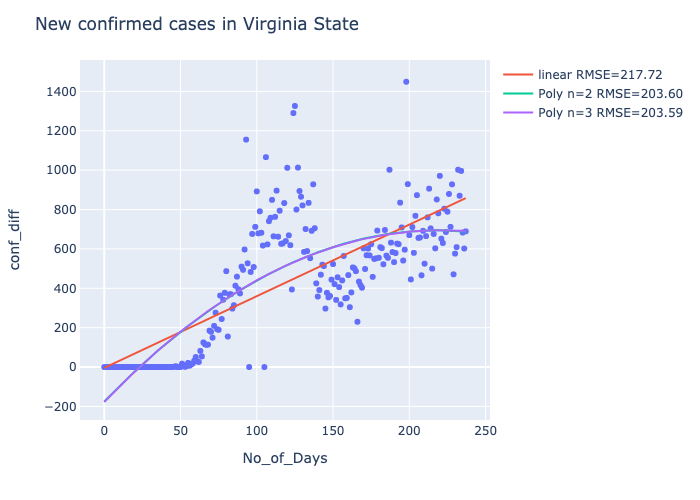

In [441]:
# create X and y
X = pd.DataFrame(VA_New_Cases_agg['No_of_Days'])
y = VA_New_Cases_agg['conf_diff']


# Linear Regression

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import make_pipeline

lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print('Intercept of linear regression model',lm.intercept_)
print('Coeficients: ',lm.coef_)

# construct final X dataframe with the minimum and maximum value of X
X_old = pd.DataFrame({'No_of_Days': [X.No_of_Days.min(), X.No_of_Days.max()]})
y_pred_train = lm.predict(X)

# RMSE - linear
# print(y_old.tolist())
rmse = np.sqrt(mean_squared_error(y.tolist(),y_pred_train.tolist()))
print('Confirmaed Cases\nRoot Mean Square error - linear regression:{}'.format(rmse))

fig = px.scatter(VA_New_Cases_agg,x="No_of_Days", y="conf_diff")
fig.update_layout(title='New confirmed cases in Virginia State')
fig.add_trace(go.Scatter(x=X['No_of_Days'].values.tolist(), y=y_pred_train.tolist(),\
                    mode='lines',name='linear RMSE=%.2f' % rmse))



# Polynomial Regression (degree 2)
degree =2
poly_reg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
model = poly_reg.fit(X,y)

y_pred_poly = model.predict(X)
# RMSE - polynomial
rmse_poly = np.sqrt(mean_squared_error(y.tolist(),y_pred_poly.tolist()))
print('Root Mean Square error - 2nd degree ploynomial:{}'.format(rmse_poly))

fig.add_trace(go.Scatter(x=X['No_of_Days'].values.tolist(), y=y_pred_poly.tolist(),\
                    mode='lines',\
                    name='Poly n=2 RMSE=%.2f' % rmse_poly))

# Polynomial Regression (degree 3)
degree =3
poly_reg3=make_pipeline(PolynomialFeatures(degree),LinearRegression())
model3 = poly_reg3.fit(X,y)

y_pred_poly3 = model3.predict(X)
# RMSE - polynomial
rmse_poly3 = np.sqrt(mean_squared_error(y.tolist(),y_pred_poly3.tolist()))
print('Root Mean Square error - 3rd degree ploynomial:{}'.format(rmse_poly3))

fig.add_trace(go.Scatter(x=X['No_of_Days'].values.tolist(), y=y_pred_poly3.tolist(),\
                    mode='lines',\
                    name='Poly n=3 RMSE=%.2f' % rmse_poly3))

fig.show()

VA_conf_trend = pio.to_image(fig,format='png')
Image(VA_conf_trend)

Intercept of linear regression model 3.7772581836081667
Coeficients:  [0.0501015]
Deaths
Root Mean Square error - linear regression:11.10844341697288
Root Mean Square error - 2nd degree ploynomial:10.223766846746338
Root Mean Square error - 3rd degree ploynomial:10.190138785314812


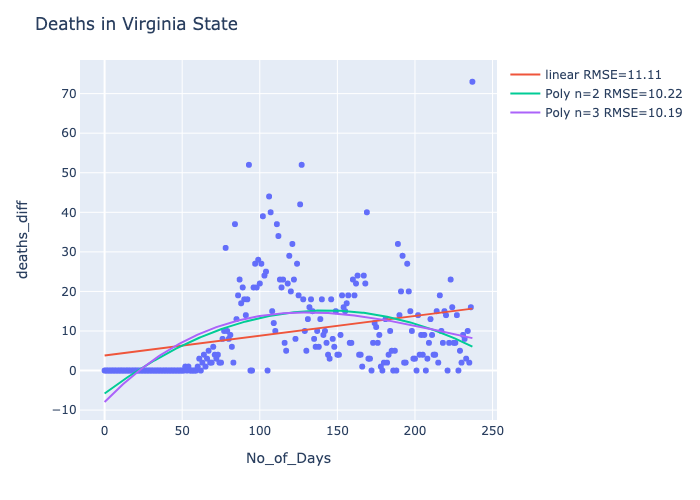

In [442]:
# 
y_deaths = VA_New_Cases_agg['deaths_diff']

lm_deaths = LinearRegression()
lm_deaths.fit(X, y_deaths)

# print intercept and coefficients
print('Intercept of linear regression model',lm_deaths.intercept_)
print('Coeficients: ',lm_deaths.coef_)


y_pred_train_d = lm_deaths.predict(X)

# RMSE - linear
# print(y_old.tolist())
rmse_deaths = np.sqrt(mean_squared_error(y_deaths.tolist(),y_pred_train_d.tolist()))
print('Deaths\nRoot Mean Square error - linear regression:{}'.format(rmse_deaths))

fig2 = px.scatter(VA_New_Cases_agg,x="No_of_Days", y="deaths_diff")
fig2.update_layout(title='Deaths in Virginia State')
fig2.add_trace(go.Scatter(x=X['No_of_Days'].values.tolist(), y=y_pred_train_d.tolist(),\
                    mode='lines',name='linear RMSE=%.2f' % rmse_deaths))



# Polynomial Regression (degree 2)
degree =2
poly_reg_d=make_pipeline(PolynomialFeatures(degree),LinearRegression())
model_d = poly_reg_d.fit(X,y_deaths)

y_pred_poly_d = model_d.predict(X)
# RMSE - polynomial
rmse_poly_d = np.sqrt(mean_squared_error(y_deaths.tolist(),y_pred_poly_d.tolist()))
print('Root Mean Square error - 2nd degree ploynomial:{}'.format(rmse_poly_d))

fig2.add_trace(go.Scatter(x=X['No_of_Days'].values.tolist(), y=y_pred_poly_d.tolist(),\
                    mode='lines',\
                    name='Poly n=2 RMSE=%.2f' % rmse_poly_d))

# Polynomial Regression (degree 3)
degree =3
poly_reg_d3=make_pipeline(PolynomialFeatures(degree),LinearRegression())
model_d3 = poly_reg_d3.fit(X,y_deaths)

y_pred_poly_d3 = model_d3.predict(X)
# RMSE - polynomial
rmse_poly_d3 = np.sqrt(mean_squared_error(y_deaths.tolist(),y_pred_poly_d3.tolist()))
print('Root Mean Square error - 3rd degree ploynomial:{}'.format(rmse_poly_d3))

fig2.add_trace(go.Scatter(x=X['No_of_Days'].values.tolist(), y=y_pred_poly_d3.tolist(),\
                    mode='lines',\
                    name='Poly n=3 RMSE=%.2f' % rmse_poly_d3))

fig2.show()

VA_deaths_trend = pio.to_image(fig2,format='png')
Image(VA_deaths_trend)

### - Compare linear and polynomial regression models for Counties of Virginia State
### - Identify which counties are most at risk. Model for top 5 counties with cases within a state and observe their trends.

#### Grouping the data for Virginia(VA) state by "County Name". Find top 5 counties with highest mean confirmed cases and deaths 
  - "Greenville County","Galax City", "Franklin city", "Emporia City" and "Buckingham County" are the top 5 counties with highest confirmed cases. The rates shown below are per 1,000,000 population.
  - "Galax City", "Emporia City", "Northampton County", "Colonial Heights city" and "Shenandoah County" are the top 5 counties with highest deaths. The rates shown below are per 1,000,000 population.

In [443]:
### -Identify counties with high case and death rates (normalized by population).

data2=[]
grouped = COVID19_VA_new_cases.groupby('County Name')
for county, group in grouped:
    popu = group['population'].iloc[1]
    a1 = group[['conf_diff','deaths_diff']]
    mean1 = ((a1.mean()/popu)*100000000).round()
    data2.append([county,mean1.iloc[0],mean1.iloc[1]])
df_all_county = pd.DataFrame(data2,columns=['County Name','conf_mean','deaths_mean'])
print('\n\nMean for new confirmed cases and death rates for each county in Virginia state (per 1,000,000).\n')
print('Counties with highest confirmed cases: \n\n{}\n'.format(df_all_county.sort_values(['conf_mean'],ascending=False).head(5).loc[:,['County Name','conf_mean']]))
print('Counties with highest deaths: \n\n{}'.format(df_all_county.sort_values(['deaths_mean'],ascending=False).head(5).loc[:,['County Name','deaths_mean']]))
top5_counties_conf = df_all_county.sort_values(['conf_mean'],ascending=False).head(5)
top5_counties_deaths = df_all_county.sort_values(['deaths_mean'],ascending=False).head(5)



Mean for new confirmed cases and death rates for each county in Virginia state (per 1,000,000).

Counties with highest confirmed cases: 

           County Name  conf_mean
48  Greensville County    27465.0
42          Galax city    26877.0
40       Franklin city    19935.0
31        Emporia city    19256.0
15   Buckingham County    16417.0

Counties with highest deaths: 

               County Name  deaths_mean
42              Galax city       1986.0
31            Emporia city       1729.0
77      Northampton County       1041.0
24   Colonial Heights city        556.0
102      Shenandoah County        530.0


### Utilized normalization by population for comparing counties
### ****Amherst county seems to have the highest upward trend(using polynomial regression plot), so this county seems to be at the higher risk of surge in the number of confirmed cases and deaths in the coming days.

In [444]:
mask_conf = COVID19_VA_new_cases['County Name'].isin(top5_counties_conf['County Name'].head())
mask_deaths = COVID19_VA_new_cases['County Name'].isin(top5_counties_deaths['County Name'].head())

data_high_conf = COVID19_VA_new_cases[mask_conf].copy()
data_high_deaths = COVID19_VA_new_cases[mask_deaths].copy()

data_high_conf['conf_diff_norm'] = ((data_high_conf['conf_diff']/data_high_conf['population'])*100000).round()
data_high_deaths['deaths_diff_norm'] = ((data_high_deaths['deaths_diff']/data_high_deaths['population'])*1000000).round()

fig12 = px.scatter(data_high_conf,x="No_of_Days", y="conf_diff_norm")
fig12.update_layout(title='New confirmed cases for counties in Virginia state')
fig12.update_traces(marker=dict(size=2,line=dict(width=1,color='DarkSlateGrey')),selector=dict(mode='markers'))
fig12['layout']['yaxis'].update(title='', range=[-20, 100], autorange=False)

fig13 = px.scatter(data_high_deaths,x="No_of_Days", y="deaths_diff_norm")
fig13.update_layout(title='Deaths in counties in Virginia state')
fig13.update_traces(marker=dict(size=2,line=dict(width=1,color='DarkSlateGrey')),selector=dict(mode='markers'))
fig13['layout']['yaxis'].update(title='', range=[-20, 60], autorange=False)

fig14 = px.scatter(data_high_conf,x="No_of_Days", y="conf_diff_norm")
fig14.update_layout(title='Prediction for 30 days - New confirmed cases for counties in Virginia state')
fig14.update_traces(marker=dict(size=2,line=dict(width=1,color='DarkSlateGrey')),selector=dict(mode='markers'))
fig14['layout']['yaxis'].update(title='', range=[-20, 100], autorange=False)

fig15 = px.scatter(data_high_deaths,x="No_of_Days", y="deaths_diff_norm")
fig15.update_layout(title='Prediction for 30 days - Deaths for counties in Virginia state')
fig15.update_traces(marker=dict(size=2,line=dict(width=1,color='DarkSlateGrey')),selector=dict(mode='markers'))
fig15['layout']['yaxis'].update(title='', range=[-20, 60], autorange=False)


grouped = data_high_conf.groupby('County Name')
for county, group in grouped:
    popu = group['population'].iloc[1]
    X_g = pd.DataFrame(group['No_of_Days'])
    y_g = group['conf_diff_norm']
    lm_g = LinearRegression()
    lm_g.fit(X_g, y_g)
    y_pred_train = lm_g.predict(X_g)

    # RMSE - linear
    rmse = np.sqrt(mean_squared_error(y_g.tolist(),y_pred_train.tolist()))

    fig12.add_trace(go.Scatter(x=X_g['No_of_Days'].values.tolist(), y=y_pred_train.tolist(),\
                        mode='lines',name=county+'-linear RMSE=%.2f' % rmse))
    
    # predict 30 days in advance - linear
    one_week = pd.DataFrame(np.arange(238,238+30),columns=['No_of_Days'])
    prediction = lm_g.predict(one_week)

    X_new = X_g.append(one_week)
    y_new = y_g.append(pd.DataFrame(prediction,columns=['conf_diff']),ignore_index=True)
    # construct final X dataframe with the minimum and maximum value of X
    X_for_pred = pd.DataFrame({'No_of_Days': [X_new.No_of_Days.min(), X_new.No_of_Days.max()]})
#     print(X_for_pred)
    y_pred_l = lm_g.predict(X_for_pred)

    fig14.add_trace(go.Scatter(x=X_for_pred['No_of_Days'].values.tolist(), \
                               y=y_pred_l.flatten().tolist(),mode='lines',\
                              name=county+'-linear'))
    
    
    # Polynomial Regression (degree 2)###########################
    degree =2
    poly_reg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    model = poly_reg.fit(X_g,y_g)

    y_pred_poly = model.predict(X_g)
    # RMSE - polynomial
    rmse_poly = np.sqrt(mean_squared_error(y_g.tolist(),y_pred_poly.tolist()))

    fig12.add_trace(go.Scatter(x=X_g['No_of_Days'].values.tolist(), y=y_pred_poly.tolist(),\
                        mode='lines',\
                        name=county+'-Poly n=2 RMSE=%.2f' % rmse_poly))
    # print intercept and coefficients
    print('Intercept of linear regression model',lm_g.intercept_)
    print('Coeficients: ',lm_g.coef_)    
    

grouped = data_high_deaths.groupby('County Name')
for county, group in grouped:
    popu = group['population'].iloc[1]
    X_g = pd.DataFrame(group['No_of_Days'])
    # for deaths #####################################################
    y_d = group['deaths_diff_norm']
    lm_d = LinearRegression()
    lm_d.fit(X_g, y_d)
    y_pred_d = lm_d.predict(X_g)

    # RMSE - linear
    rmsed = np.sqrt(mean_squared_error(y_d.tolist(),y_pred_d.tolist()))
    
    fig13.add_trace(go.Scatter(x=X_g['No_of_Days'].values.tolist(), y=y_pred_d.tolist(),\
                        mode='lines',name=county+'-linear RMSE=%.2f' % rmsed))
    # predict 30 days in advance - linear
    prediction_d = lm_d.predict(one_week)

    y_new_d = y_d.append(pd.DataFrame(prediction_d,columns=['deaths_diff_norm']),ignore_index=True)
    # construct final X dataframe with the minimum and maximum value of X
    X_for_pred_d = pd.DataFrame({'No_of_Days': [X_new.No_of_Days.min(), X_new.No_of_Days.max()]})
#     print(X_for_pred)
    y_pred_p = lm_d.predict(X_for_pred_d)

    fig15.add_trace(go.Scatter(x=X_for_pred_d['No_of_Days'].values.tolist(), \
                               y=y_pred_p.flatten().tolist(),mode='lines',\
                              name=county+'-linear'))


    # Polynomial Regression (degree 2)########
    degree =2
    poly_reg_d=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    model_d = poly_reg_d.fit(X_g,y_d)

    y_pred_poly_d = model_d.predict(X_g)
    # RMSE - polynomial
    rmse_poly_d = np.sqrt(mean_squared_error(y_d.tolist(),y_pred_poly_d.tolist()))

    fig13.add_trace(go.Scatter(x=X_g['No_of_Days'].values.tolist(), y=y_pred_poly_d.tolist(),\
                        mode='lines',\
                        name=county+'-Poly n=2 RMSE=%.2f' % rmse_poly_d))
    # print intercept and coefficients
    print('Intercept of linear regression model',lm_d.intercept_)
    print('Coeficients: ',lm_d.coef_)




Intercept of linear regression model 12.513026968109415
Coeficients:  [0.03297165]
Intercept of linear regression model -0.2655321542843154
Coeficients:  [0.16474122]
Intercept of linear regression model -17.367814071235184
Coeficients:  [0.31551749]
Intercept of linear regression model 3.462149713441857
Coeficients:  [0.19813525]
Intercept of linear regression model -7.22260117436096
Coeficients:  [0.2928759]
Intercept of linear regression model 3.6136915017052837
Coeficients:  [0.01662736]
Intercept of linear regression model -4.135684399282727
Coeficients:  [0.1807713]
Intercept of linear regression model -7.447206497661824
Coeficients:  [0.23059374]
Intercept of linear regression model 8.89666326781759
Coeficients:  [0.01260838]
Intercept of linear regression model 0.06388664252311926
Coeficients:  [0.04431426]


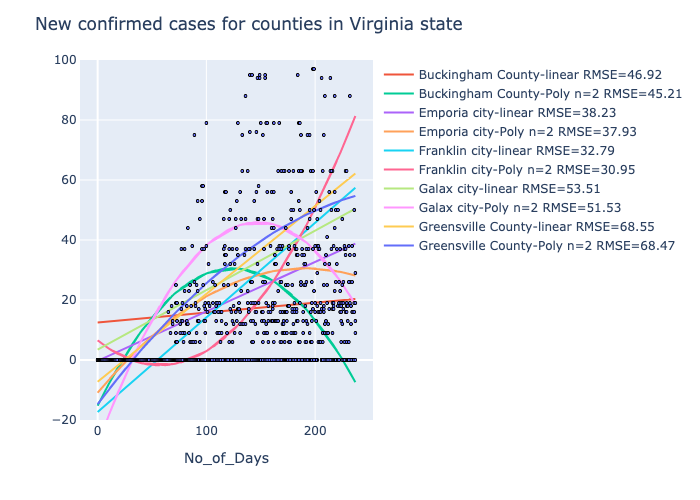

In [445]:
fig12.show()
VA_conf_counties = pio.to_image(fig12,format='png')
Image(VA_conf_counties)

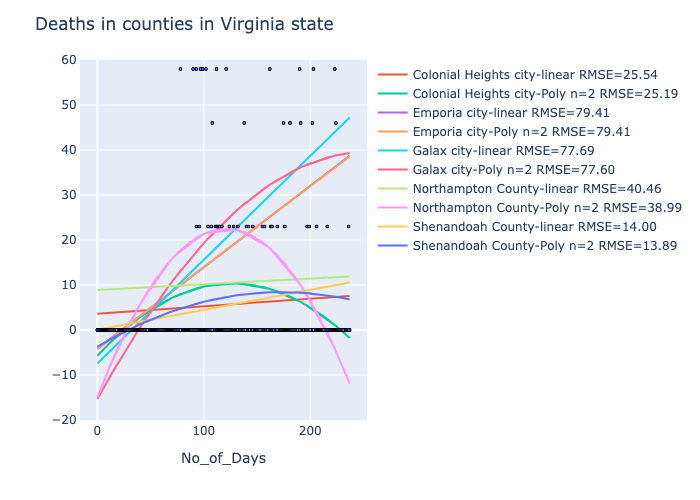

In [446]:
fig13.show()

VA_deaths_counties = pio.to_image(fig13,format='png')
Image(VA_deaths_counties)


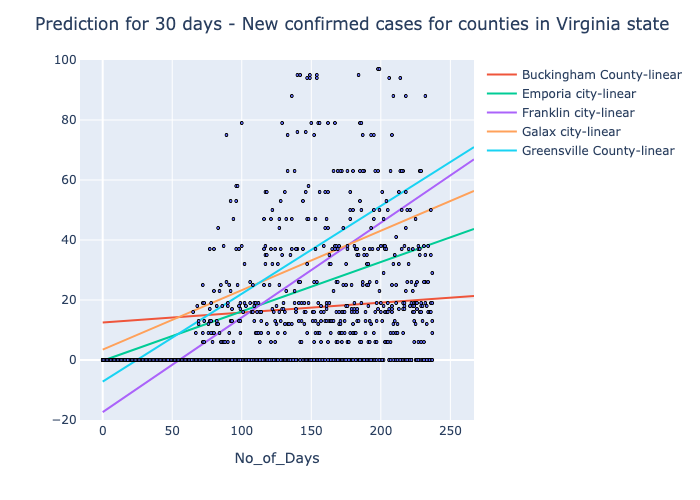

In [447]:
fig14.show()
VA_conf_pred = pio.to_image(fig14,format='png')
Image(VA_conf_pred)

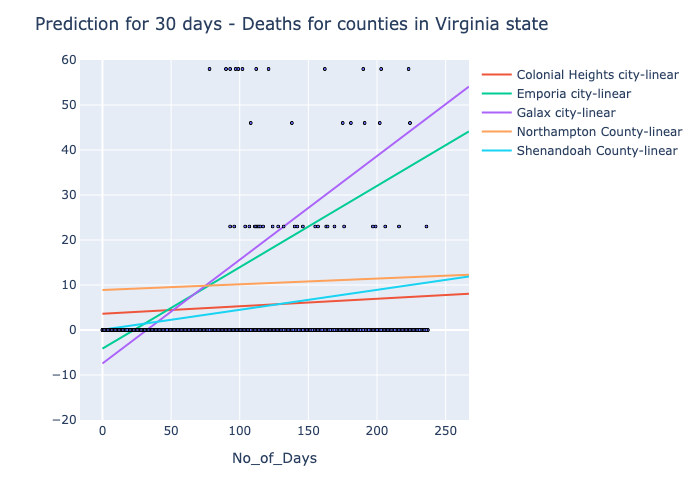

In [448]:
fig15.show()
VA_deaths_pred = pio.to_image(fig15,format='png')
Image(VA_deaths_pred)

### -Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

In [449]:

# Read the COVID 19 csv file
covid_data = pd.read_csv("../Data/Output/Merged_COVID19_file.csv")
covid_data.columns
print(covid_data.columns)
# hospital beds
hospital_beds = pd.read_csv("../Data/Input/Definitive_Healthcare_Hospital_Beds_0914.csv")
# print(hospital_beds.columns)



# calculate total numbe rof ICU Beds in each state
hos_beds = hospital_beds.groupby('STATE_FIPS')[['NUM_ICU_BEDS','ADULT_ICU_BEDS','PEDI_ICU_BEDS']].sum()
hos_total_ICU_beds = pd.DataFrame(hos_beds.sum(axis=1),columns=['Total ICU Beds'])

data=[]
grouped = merged_COVID19.groupby('stateFIPS')
for state, group in grouped:
    popu = group.groupby('dates')['population'].sum()[1]
    a1 = group.groupby(['dates'])['deaths'].sum().diff()
    a2 = a1.sum()
    data.append([state,a2])
df_all_states = pd.DataFrame(data,columns=['stateFIPS','Total number of deaths'])
# print(hos_total_ICU_beds)
# print('\n\nMean/Median/Mode for new confirmed cases and death rates for each state in the whole US (per 1,000,000).\n')
# print('States with highest confirmed cases: \n\n{}\n'.format(df_all_states.sort_values(['conf_mean'],ascending=False).head(5).loc[:,['State','conf_mean','conf_median','conf_mode']]))
# print('States with highest deaths: \n\n{}'.format(df_all_states.sort_values(['deaths_mean'],ascending=False).head(5).loc[:,['State','deaths_mean','deaths_median','deaths_mode']]))
# df_all_states.sort_values(['conf_mean'],ascending=False)

df_final = df_all_states.merge(hos_total_ICU_beds,left_on='stateFIPS',right_index=True,how='left')
df_final.head()

Index(['countyFIPS', 'stateFIPS', 'dates', 'County Name', 'State',
       'population', 'confirmed_cases', 'deaths'],
      dtype='object')


,stateFIPS,Total number of deaths,Total ICU Beds
0,1,2387.0,3843.0
1,2,44.0,462.0
2,4,5344.0,4296.0
3,5,1010.0,2075.0
4,6,14615.0,21162.0


### The states where the total number of deaths are higher than the total number of ICU beds available are as below. These states have reached point of no return.


In [450]:
df_final_no_point = df_final[df_final['Total ICU Beds']<df_final['Total number of deaths']]
print('The states where the total number of deaths are higher than the total number of ICU beds available are as below:')
df_final_no_point

The states where the total number of deaths are higher than the total number of ICU beds available are as below:


,stateFIPS,Total number of deaths,Total ICU Beds
2,4,5344.0,4296.0
6,9,4485.0,2196.0
7,10,618.0,549.0
20,24,3901.0,2984.0
21,25,9224.0,4236.0
22,26,6932.0,5690.0
24,28,2734.0,2435.0
30,34,16043.0,4186.0
32,36,32729.0,10374.0
39,44,1042.0,830.0


### -Utilize decision tree, random forest, and ARIMA (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases.

    - ARIMA model performed best among Decision Tree and Random Forest with the least Root Mean Square Error.
    - RMSE for ARIMA - 204.979
    - RMSE for Decision Tree - 339.94
    - RMSE for Random Forest - 232.48

Index(['conf_diff'], dtype='object')
[625.05 625.05 625.05 625.05 625.05 625.05 625.05]
[471. 471. 471. 471. 471. 471. 471.]
RMSE - Random Forest: 222.405266
RMSE - Decision Tree: 339.949786
predicted=654.581191, expected=576.000000
predicted=538.402904, expected=609.000000
predicted=599.787227, expected=1002.000000
predicted=855.115295, expected=870.000000
predicted=926.456338, expected=996.000000
predicted=952.850776, expected=683.000000
predicted=810.092386, expected=602.000000
Test RMSE: 204.979


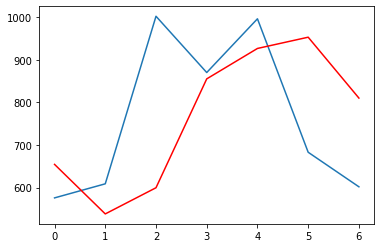

In [451]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
# COVID19_VA_new_cases = COVID19_VA_new_cases.sort_values('No_of_Days')
# Split the data into Train and Test, all data - last week data = Previous weeks data and it is for training,
# last week data is for testing
previous_weeks = pd.DataFrame(np.arange(0,237-7),columns=['No_of_Days'])
last_week = pd.DataFrame(np.arange(237-7,237),columns=['No_of_Days'])
grouped = pd.DataFrame(COVID19_VA_new_cases.groupby('dates')['conf_diff'].sum())
print(grouped.columns)
X_train = previous_weeks
X_test = last_week 
y_train = grouped['conf_diff'].iloc[0:237-7]
y_test = grouped['conf_diff'].iloc[237-7:237]

# Utilize Decision Tree
regressor_DT = DecisionTreeRegressor(random_state = 0)    
# fit the regressor with X and Y data 
regressor_DT.fit(X_train, y_train)

# Utilize random forest
regressor_r = RandomForestRegressor()
regressor_r.fit(X_train, y_train)

# predict using all the trained models and then test
y_pred_RF = regressor_r.predict(X_test)
y_pred_DT = regressor_DT.predict(X_test)
print(y_pred_RF)
print(y_pred_DT)
# RMSE - polynomial
rmse_RF = np.sqrt(mean_squared_error(y_test.tolist(),y_pred_RF.tolist()))
rmse_DT = np.sqrt(mean_squared_error(y_test.tolist(),y_pred_DT.tolist()))

# print Root Mean Square Error
print('RMSE - Random Forest: %3f'% rmse_RF)
print('RMSE - Decision Tree: %3f'%rmse_DT)



# Utilize ARIMA
from statsmodels.tsa.arima_model import ARIMA

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

X_ARIMA = grouped.values
# size = int(len(X_ARIMA) * 0.66)
train, test = X_ARIMA[0:237-7], X_ARIMA[237-7:237]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county. Compare Random Forest and Decision Trees (RMSE error).
    - For example, percentage of population in certain age-group, socio-economic status, public transportation, work from home, etc.
    - Show the relative importance of variables and explain why.
#### Consolidated Hospital beds data, county wise , normalized the data , trained and tested DT and RF models, Feature importance calculated
#### - RMSE for confirmed cases- Random Forest: 97.222668; Decision Tree: 132.287868
    - Low the RMSE, better is the regressor. Root mean square error is low for random forest than Decision Tree, so we can say in this case Random Forest performs well.
#### - RMSE for deaths- Random Forest: 8.387709; Decision Tree: 10.1239
    - Low the RMSE, better is the regressor. RMSE is low for random forest than Decision Tree, so we can say in this case too Random Forest performs well.
 - NUM_STAFFED_BEDS has the highest importance when we calculated the importance score

RMSE for confirmed cases - Random Forest: 98.495683
RMSE for confirmed cases - Decision Tree: 132.287868
RMSE for deaths - Random Forest: 8.678572
RMSE for deaths - Decision Tree: 10.123922
#####################################################
Index(['population', 'NUM_STAFFED_BEDS', 'NUM_ICU_BEDS', 'ADULT_ICU_BEDS',
       'BED_UTILIZATION', 'AVG_VENTILATOR_USAGE'],
      dtype='object')
#####################################################
Confirmed cases- RF
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.54162
Feature: 2, Score: 0.15090
Feature: 3, Score: 0.11405
Feature: 4, Score: 0.11095
Feature: 5, Score: 0.08247


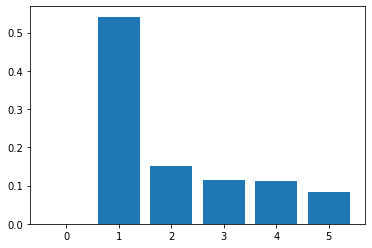

Confirmed cases- DT
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.76479
Feature: 2, Score: 0.20136
Feature: 3, Score: 0.00652
Feature: 4, Score: 0.02733
Feature: 5, Score: 0.00000


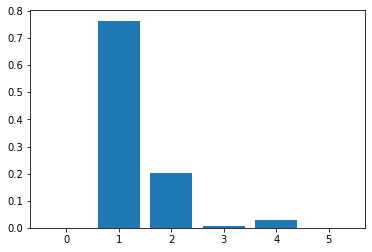

Deaths- RF
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.59176
Feature: 2, Score: 0.06909
Feature: 3, Score: 0.09981
Feature: 4, Score: 0.10103
Feature: 5, Score: 0.13832


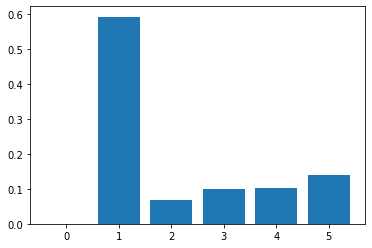

Deaths- DT
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.83435
Feature: 2, Score: 0.03054
Feature: 3, Score: 0.02189
Feature: 4, Score: 0.07951
Feature: 5, Score: 0.03372


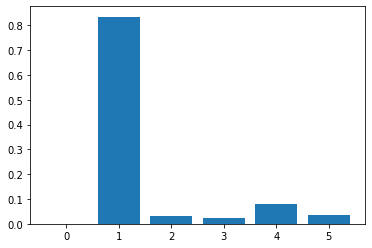

In [457]:
from sklearn.model_selection import train_test_split
# Read the COVID 19 hospital beds combined csv file
covid_beds = pd.read_csv("../Data/Output/COVID19_Enrichment_Combined.csv")
covid_beds.columns

# Dropping duplicate columns and unnecessary columns
covid_beds = covid_beds.drop(['Unnamed: 0'],axis=1).fillna(0)

# Choose data for state "VA" every day new cases
covid_beds_VA = covid_beds[covid_beds['State']=='VA'].copy()
covid_beds_VA_last_day = covid_beds_VA[covid_beds_VA['dates']=='9/15/20']
a1 = covid_beds_VA.groupby('County Name')['NUM_STAFFED_BEDS','NUM_LICENSED_BEDS','NUM_ICU_BEDS',\
                                                   'ADULT_ICU_BEDS','PEDI_ICU_BEDS','BED_UTILIZATION',\
                                                   'Potential_Increase_In_Bed_Capac','AVG_VENTILATOR_USAGE'].sum().reset_index()
a2 = covid_beds_VA_last_day.groupby('County Name')[['confirmed_cases','deaths','population']].mean()
covid_beds_VA_agg = a2.merge(a1,on='County Name').set_index('County Name')

covid_beds_VA_agg_norm = (covid_beds_VA_agg.div(a2['population'],axis=0))*10000
# covid_beds_VA_agg = covid_beds_VA_agg[covid_beds_VA_agg['County Name']=='Fairfax County']

X_enrichment = covid_beds_VA_agg_norm.drop(['NUM_LICENSED_BEDS','PEDI_ICU_BEDS','Potential_Increase_In_Bed_Capac','confirmed_cases','deaths'],axis=1)
y_conf = covid_beds_VA_agg_norm['confirmed_cases']
y_deaths = covid_beds_VA_agg_norm['deaths']

################## Confirmed Cases ####################################

# training and testing using Random forest and Decision Trees (Confirmed Cases)
X_train, X_test, y_train, y_test = train_test_split(X_enrichment, y_conf, test_size=0.30, random_state=42)

# Utilize Decision Tree
regressor_DT = DecisionTreeRegressor(random_state = 0)    
# fit the regressor with X and Y data 
regressor_DT.fit(X_train, y_train)

# Utilize random forest
regressor_r = RandomForestRegressor()
regressor_r.fit(X_train, y_train)

# predict using all the trained models and then test
y_pred_RF = regressor_r.predict(X_test)
y_pred_DT = regressor_DT.predict(X_test)

# RMSE - polynomial
rmse_RF = np.sqrt(mean_squared_error(y_test.tolist(),y_pred_RF.tolist()))
rmse_DT = np.sqrt(mean_squared_error(y_test.tolist(),y_pred_DT.tolist()))

# print Root Mean Square Error
print('RMSE for confirmed cases - Random Forest: %3f'% rmse_RF)
print('RMSE for confirmed cases - Decision Tree: %3f'%rmse_DT)

#################### Deaths #############################
# training and testing using Random forest and Decision Trees (Confirmed Cases)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_enrichment, y_deaths, test_size=0.30, random_state=42)

# Utilize Decision Tree
regressor_DT_1 = DecisionTreeRegressor(random_state = 0)    
# fit the regressor with X and Y data 
regressor_DT_1.fit(X_train1, y_train1)

# Utilize random forest
regressor_r_1 = RandomForestRegressor()
regressor_r_1.fit(X_train1, y_train1)

# predict using all the trained models and then test
y_pred_RF_1 = regressor_r_1.predict(X_test1)
y_pred_DT_1 = regressor_DT_1.predict(X_test1)

# RMSE - polynomial
rmse_RF_1 = np.sqrt(mean_squared_error(y_test1.tolist(),y_pred_RF_1.tolist()))
rmse_DT_1 = np.sqrt(mean_squared_error(y_test1.tolist(),y_pred_DT_1.tolist()))

# print Root Mean Square Error
print('RMSE for deaths - Random Forest: %3f'% rmse_RF_1)
print('RMSE for deaths - Decision Tree: %3f'%rmse_DT_1)
print('#####################################################')
print(X_enrichment.columns)
print('#####################################################')


#####################Feature Importance ##############
print('Confirmed cases- RF')
importance_RF = regressor_r.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_RF):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_RF))], importance_RF)
plt.show()
print('Confirmed cases- DT')


importance_DT = regressor_DT.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_DT):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_DT))], importance_DT)
plt.show()
print('Deaths- RF')


importance_RF_1 = regressor_r_1.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_RF_1):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_RF_1))], importance_RF_1)
plt.show()
print('Deaths- DT')


importance_DT_1 = regressor_DT_1.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_DT_1):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_DT_1))], importance_DT_1)
plt.show()

## Task 2: 
####    Member: For each of the aforemention analysis plot graphs,
        - trend line
        - confidence intervals (error in prediction)
        - prediction path

### The trend lines for confirmed cases and deaths in Virginia state are as below:

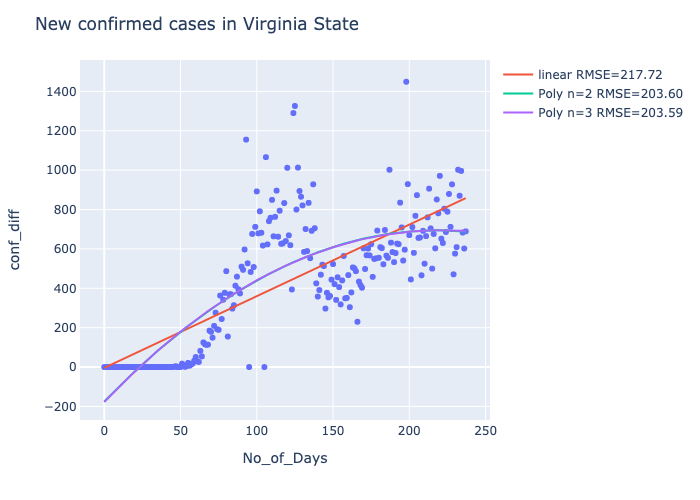

In [458]:
Image(VA_conf_trend)

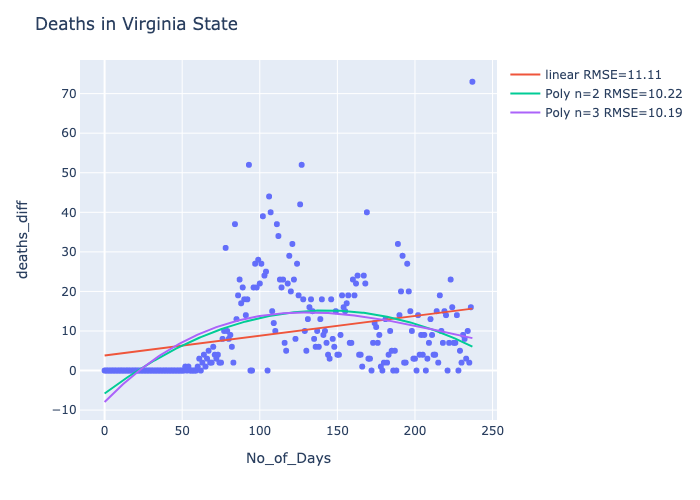

In [459]:

Image(VA_deaths_trend)

### confidence intervals (error in prediction) for data in Virginia State

z-critical value:
1.959963984540054
Sample Mean:
2.337
Confidence interval:
(1.4286416080770101, 3.2453583919229905)


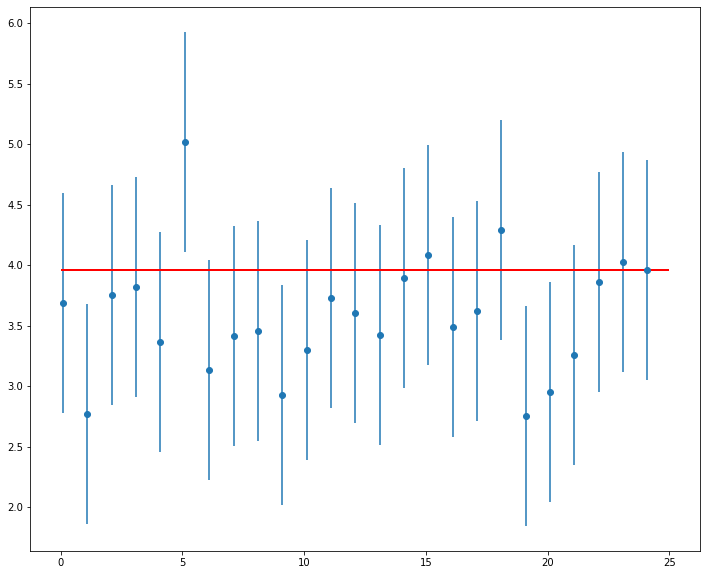

In [460]:
import scipy.stats as stats
import math
# confirmed cases
sample_size = 1000

conf_cases = COVID19_VA_new_cases['conf_diff']
# find confidence interval for q = .975
sample = np.random.choice(a= conf_cases, size = sample_size)
sample_mean = sample.mean()

z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value*

print("z-critical value:")              # Check the z-critical value
print(z_critical)                        

pop_stdev = conf_cases.std()  # Get the population standard deviation

margin_of_error = z_critical * (pop_stdev/math.sqrt(sample_size))

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Sample Mean:")
print(sample_mean)

print("Confidence interval:")
print(confidence_interval)
# calculate confidence interval for various sample sizes and  
intervals = []
sample_means = []

for sample in range(25):
    sample = np.random.choice(a= conf_cases, size = sample_size)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)

    z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value*         

    pop_stdev = conf_cases.std()  # Get the population standard deviation

    stats.norm.ppf(q = 0.025)

    margin_of_error = z_critical * (pop_stdev/math.sqrt(sample_size))

    confidence_interval = (sample_mean - margin_of_error,
                           sample_mean + margin_of_error)  
    
    intervals.append(confidence_interval)

plt.figure(figsize=(12,10))

plt.errorbar(x=np.arange(0.1, 25, 1), 
             y=sample_means, 
             yerr=[(top-bot)/2 for top,bot in intervals],
             fmt='o')

plt.hlines(xmin=0, xmax=25,
           y=sample_mean, 
           linewidth=2.0,
           color="red")

### prediction path for confirmed cases and deaths in Virginia State
    - This prediction path is constructed by normalizing the data for top 5 counties by population
    - I have predicted for next 30 days instead of just 7 days so I can see where the graph is going
    - I have plotted the predcition path for all 5 counties in one plot so I can clearly see and visually comapre the slope of each line. This comparision easily lets me figure out the high risk county in next 30 days

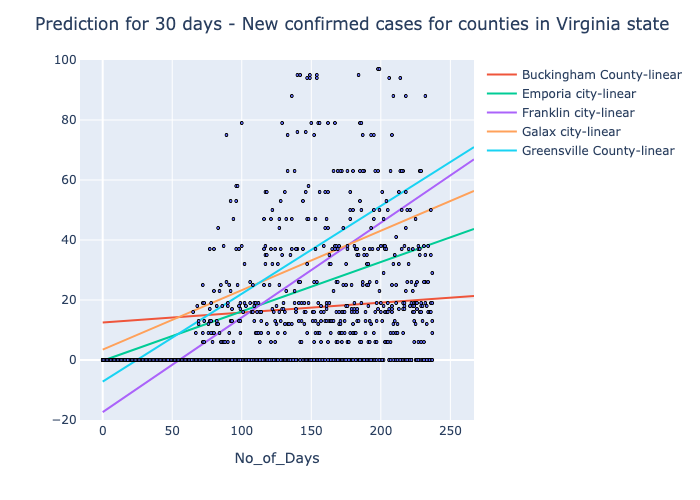

In [461]:
Image(VA_conf_pred)

### This prediction path for Deaths is constructed by normalizing the data for top 5 counties by population
    - I have predicted for next 30 days instead of just 7 days so I can see where the graph is going
    - I have plotted the prediction path for all 5 counties in one plot so I can clearly see and visually comapre the slope of each line. This comparision easily lets me figure out the high risk county in next 30 days

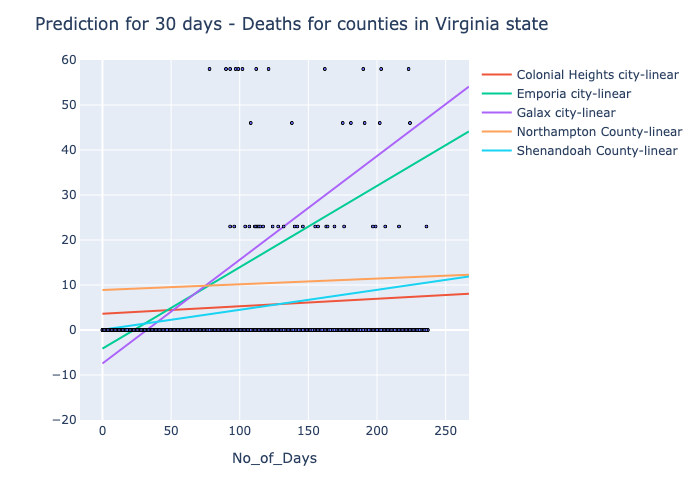

In [462]:
Image(VA_deaths_pred)